# Exploratory analysis with historical transactions

In [4]:
# Library imports
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid', font_scale = 1.5, color_codes=True)
import os
import matplotlib.pyplot as plt
import numpy as np

# Constants
n_rows_to_load = 10000000

In [5]:
# Import the origin datasets that we will be using
hist_transactions = pd.read_csv("/home/nikolaevra/datasets/elo/historical_transactions.csv", nrows=n_rows_to_load)
train_set = pd.read_csv("/home/nikolaevra/datasets/elo/train.csv", index_col='card_id', parse_dates=["first_active_month"])

##  Target variable (loyalty score)

Some inspiration analysis comes from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

Statistics of target column (loyalty score)

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64


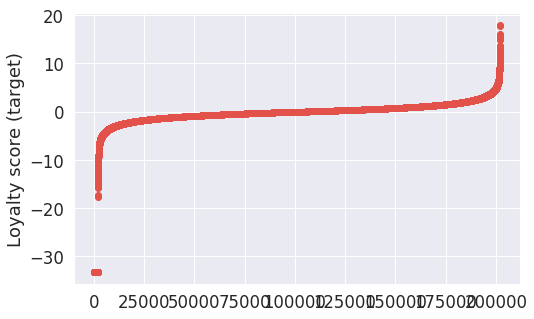

In [6]:
# Plot the target value to see what type of scores we are looking for
 
print("Statistics of target column (loyalty score)\n")

print(train_set['target'].describe())

plt.figure(figsize=(8,5))
plt.scatter(range(0,len(train_set)), np.sort(train_set['target'].values))
plt.ylabel('Loyalty score (target)')
plt.savefig('loyalty_score_distribution.png')
plt.show()

We can see that majority of scores are in (-1,1) range with some extreme outliers in either direction.

## Identifying linear relationships between variables

*Hint: we have found none of statistical significance*

In [7]:
# Truncate data to only include transactions in 2017
hist_transactions = hist_transactions[(hist_transactions['purchase_date'] >= '2017-01-01 00:00:00') & (hist_transactions['purchase_date'] < '2018-01-01 00:00:00')]

In [8]:
hist_train = pd.merge(
    hist_transactions,
    train_set,
    how='inner',
    left_on='card_id',
    right_index=True,
    suffixes=('_trans', '_train')
)

hist_groupby_id = hist_train[['card_id', 'purchase_amount','merchant_id']].groupby('card_id').agg({
    'purchase_amount': {
        'purchase_mean': 'mean',
        'purchase_sum': 'sum',
        'purchase_max': 'max',
        'n_transactions': 'count'
    },
    'merchant_id': 'nunique'
})

/home/nikolaevra/.local/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [9]:
hist_groupby_id_w_train = pd.merge(
    pd.merge(hist_groupby_id['purchase_amount'],hist_groupby_id['merchant_id'],on="card_id"),
    train_set,
    how="inner", # only look at it if it exists in the train set
    left_index=True,
    right_index=True)

hist_groupby_id_w_train.rename(columns={'nunique':'n_unique_merchants'},inplace=True)

Use pairplots to check if there is a relationship between any purchase amount statistic and the loyalty score that seems to be immediately apparent.

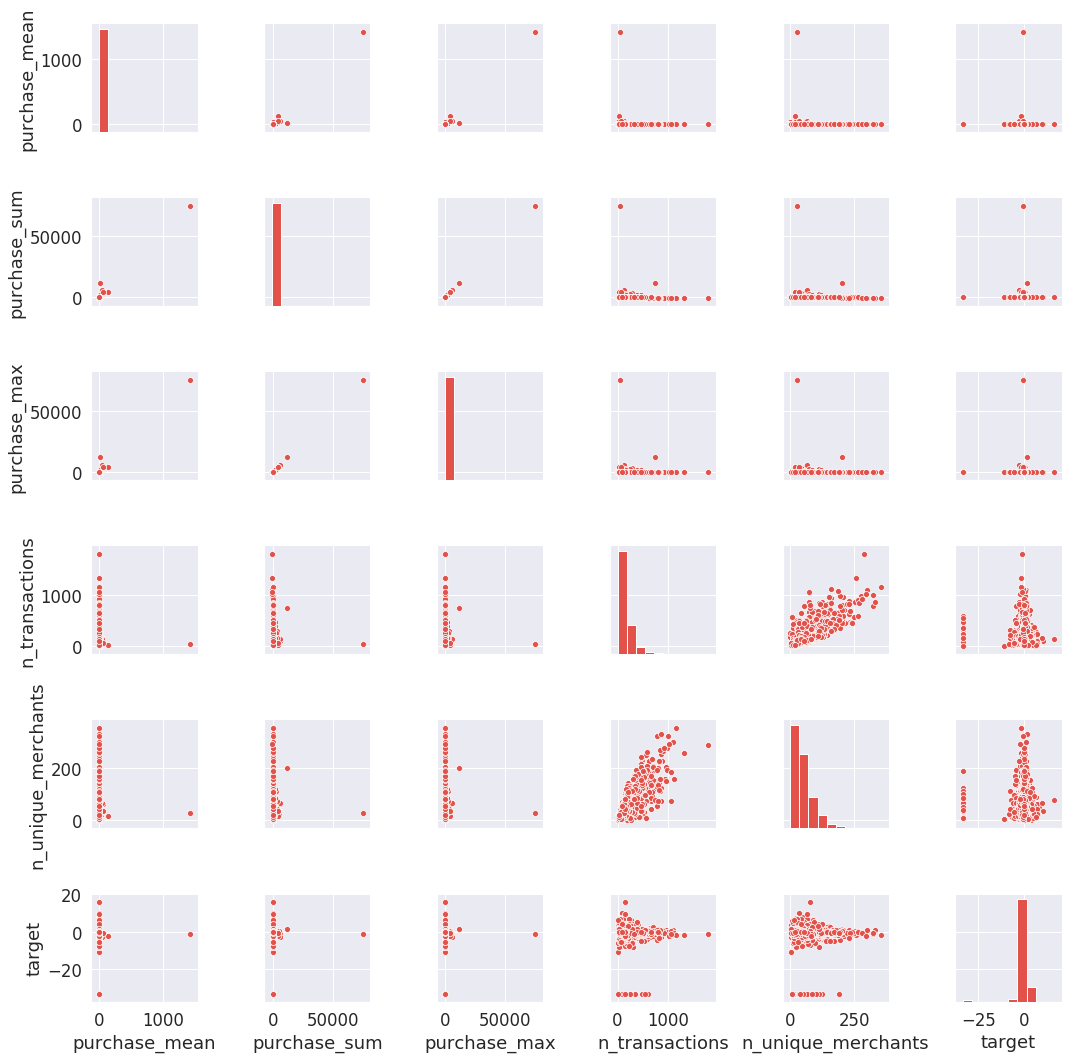

In [10]:
cols_to_show = [
    'purchase_mean',
    'purchase_sum',
    'purchase_max',
    'n_transactions',
    'n_unique_merchants',
    'target'
]

pplot = sns.pairplot(hist_groupby_id_w_train[cols_to_show].dropna().sample(5000))
pplot.savefig("pair_plot_transactions.png")
pplot.show()

The most interesting result we see here is that as the number of transactions increases, we see that the deviation of the loyalty score starts to decrease. We see the same decrease in variability as a user's mean, total, and max purchase amounts increase, but to a much lesser extent.